## Importing the necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Ignoring all warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
model_df = pd.read_csv('Bengaluru_House_Data_EDA.csv')

In [3]:
model_df.shape

(12448, 9)

In [4]:
model_df.head()

,area_type,availability,location,society,total_sqft,bath,balcony,price,Month_of_Availability
0,Plot Area,Ready To Move,Sarjapur,In society,2250.0,3,2,149.000,0
1,Super built-up Area,Not Ready To Move,Thanisandra,In society,510.0,1,0,27.625,11
2,Super built-up Area,Not Ready To Move,Mangammanapalya,Not in society,1250.0,3,2,56.000,5
3,Super built-up Area,Ready To Move,Electronic City,In society,660.0,1,1,23.100,0
4,Built-up Area,Not Ready To Move,Whitefield,Not in society,1610.0,3,2,81.000,12


## Data Preprocessing for Model Building

### Reducing categories for Categorical Columns

#### Location column

In [5]:
model_df['location'].value_counts()

Whitefield                        513
Sarjapur  Road                    367
Electronic City                   270
Kanakpura Road                    235
Thanisandra                       221
                                 ... 
asha township, off hennur road      1
Escorts Colony                      1
Rahat Bagh                          1
Chokkasandra                        1
Abshot Layout                       1
Name: location, Length: 1296, dtype: int64

In [6]:
# Percentage of unique values in 'location' column
model_df['location'].nunique() / model_df.shape[0] * 100

10.411311053984576

In [7]:
model_df['location'] = model_df['location'].apply(lambda x : x.strip())
model_df['location'] = model_df['location'].apply(lambda x : x.lower())
model_df['location'] = model_df['location'].apply(lambda x : x.replace(' road', '') if ' road' in x else x)

In [8]:
location_lt_10 = model_df['location'].value_counts()[model_df['location'].value_counts() <= 10]
location_lt_10

dairy circle         10
btm 1st stage        10
lb shastri nagar     10
kalkere              10
dodsworth layout     10
                     ..
vidyapeeta            1
maruthi extension     1
okalipura             1
old town              1
abshot layout         1
Name: location, Length: 1039, dtype: int64

In [9]:
len(location_lt_10)

1039

In [10]:
# If value counts is less than or equal to 25, then adding to 'Other' category
model_df['location'] = model_df['location'].apply(lambda x : 'Other' if x in location_lt_10 else x)

In [11]:
model_df['location'].value_counts()

Other              2857
whitefield          514
sarjapur            367
electronic city     272
kanakpura           235
                   ... 
kodigehalli          11
tindlu               11
isro layout          11
nagasandra           11
banjara layout       11
Name: location, Length: 229, dtype: int64

###### We were able to reduce the number of categories in 'location' column from 1296 to 111.

### Outliers Detection for Numeric Columns

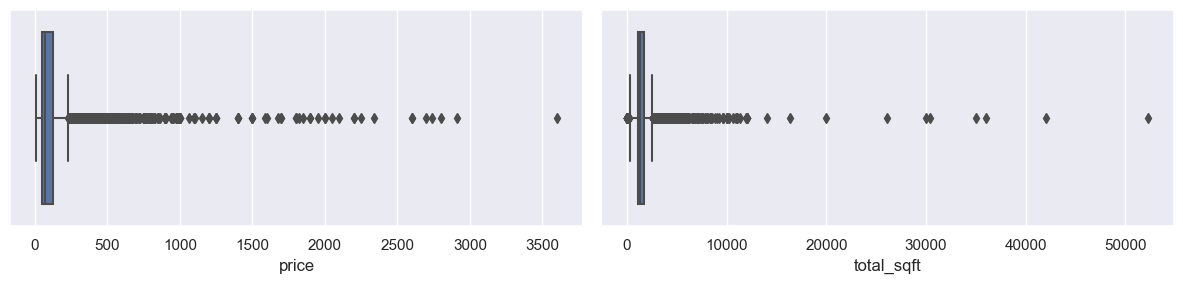

In [12]:
plt.figure(figsize = (12, 3))
x = 1

for column in ['price', 'total_sqft']:
    plt.subplot(1, 2, x)
    sns.boxplot(model_df[column])
    x += 1

plt.tight_layout()

###### Both price and total_sqft have outliers and these must be treated.

In [13]:
model_df['price'] = np.where(model_df['price'] > 3000, model_df['price'].median(), model_df['price'])
model_df['total_sqft'] = np.where(model_df['total_sqft'] > 19000, model_df['total_sqft'].median(), model_df['total_sqft'])

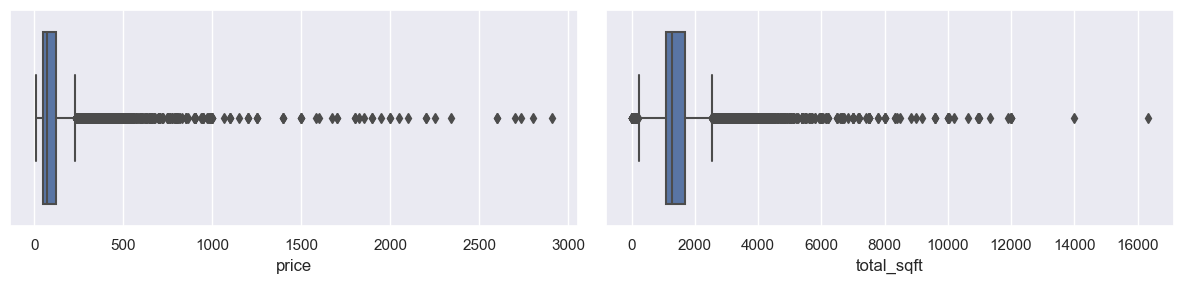

In [14]:
plt.figure(figsize = (12, 3))
x = 1

for column in ['price', 'total_sqft']:
    plt.subplot(1, 2, x)
    sns.boxplot(model_df[column])
    x += 1

plt.tight_layout()

### Skewness Treatment

In [15]:
model_df.skew()

total_sqft               4.053391
bath                     4.258895
balcony                 -0.055397
price                    7.472747
Month_of_Availability    2.234860
dtype: float64

###### The skewness of total_sqft, bath, Month_of_Availability and price columns can be reduced by using cube root transformations twice.

In [16]:
model_df['total_sqft'] = np.cbrt(model_df['total_sqft'])
model_df['total_sqft'] = np.cbrt(model_df['total_sqft'])
model_df['bath'] = np.cbrt(model_df['bath'])
model_df['bath'] = np.cbrt(model_df['bath'])
model_df['Month_of_Availability'] = np.cbrt(model_df['Month_of_Availability'])
model_df['Month_of_Availability'] = np.cbrt(model_df['Month_of_Availability'])
model_df['price'] = np.cbrt(model_df['price'])
model_df['price'] = np.cbrt(model_df['price'])

In [17]:
model_df.skew()

total_sqft              -0.127866
bath                     0.628514
balcony                 -0.055397
price                    1.140669
Month_of_Availability    1.496225
dtype: float64

In [18]:
model_df.duplicated().sum()

71

In [19]:
model_df.drop_duplicates(inplace = True)  # Duplicate rows dropped

### Encoding the Data

In [20]:
model_df.describe(include = ['O']).columns

Index(['area_type', 'availability', 'location', 'society'], dtype='object')

In [21]:
model_df = pd.get_dummies(model_df, columns = ['area_type', 'availability', 'location', 'society'], drop_first = True)

In [22]:
model_df.shape

(12377, 238)

In [23]:
model_df.head()

,total_sqft,bath,balcony,price,Month_of_Availability,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_Ready To Move,location_1st phase jp nagar,location_2nd stage nagarbhavi,location_5th block hbr layout,location_5th phase jp nagar,location_6th phase jp nagar,location_7th phase jp nagar,location_8th phase jp nagar,location_9th phase jp nagar,location_Other,location_abbigere,location_aecs layout,location_akshaya nagar,location_ambalipura,location_ambedkar nagar,location_amruthahalli,location_anandapura,location_ananth nagar,location_anekal,location_anjanapura,location_ardendale,location_arekere,location_attibele,location_babusapalaya,location_balagere,location_banashankari,location_banashankari stage ii,location_banashankari stage iii,location_banashankari stage v,location_banashankari stage vi,location_banaswadi,location_banjara layout,location_bannerghatta,location_basavangudi,location_basaveshwara nagar,location_battarahalli,location_begur,location_bellandur,location_benson town,location_bharathi nagar,location_bhoganhalli,location_billekahalli,location_binny pete,location_bisuvanahalli,location_bommanahalli,location_bommasandra,location_bommasandra industrial area,location_bommenahalli,location_brookefield,location_btm 2nd stage,location_btm layout,location_budigere,location_chamrajpet,location_chandapura,location_channasandra,location_chikka tirupathi,location_chikkabanavar,location_chikkalasandra,location_choodasandra,location_cooke town,location_cox town,location_cunningham,location_cv raman nagar,location_dasanapura,location_dasarahalli,location_devanahalli,location_devarachikkanahalli,location_dodda nekkundi,location_doddaballapur,location_doddakallasandra,location_doddathoguru,location_domlur,location_dommasandra,location_electronic city,location_electronic city phase ii,location_electronics city phase 1,location_epip zone,location_frazer town,location_garudachar palya,location_giri nagar,location_gm palaya,location_gollarapalya hosahalli,location_gottigere,location_green glen layout,location_gubbalala,location_gunjur,location_hal 2nd stage,location_haralur,location_harlur,location_hbr layout,location_hebbal,location_hebbal kempapura,location_hegde nagar,location_hennur,location_hoodi,location_horamavu agara,location_horamavu banaswadi,location_hormavu,location_hosa,location_hosakerehalli,location_hoskote,location_hosur,location_hrbr layout,location_hsr layout,location_hulimavu,location_iblur village,location_indira nagar,location_isro layout,location_itpl,location_jakkur,location_jalahalli,location_jalahalli east,location_jigani,location_jp nagar,location_judicial layout,location_kadubeesanahalli,location_kadugodi,location_kaggadasapura,location_kaggalipura,location_kaikondrahalli,location_kalena agrahara,location_kalyan nagar,location_kambipura,location_kammanahalli,location_kammasandra,location_kanakapura,location_kanakpura,location_kannamangala,location_karuna nagar,location_kasavanhalli,location_kasturi nagar,location_kathriguppe,location_kaval byrasandra,location_kenchenahalli,location_kengeri,location_kengeri satellite town,location_kereguddadahalli,location_kodichikkanahalli,location_kodigehaali,location_kodigehalli,location_kodihalli,location_kogilu,location_konanakunte,location_koramangala,location_kothannur,location_kothanur,location_kr puram,location_kudlu,location_kudlu gate,location_kumaraswami layout,location_kundalahalli,location_laggere,location_lakshminarayana pura,location_lingadheeranahalli,location_magadi,location_mahadevpura,location_mahalakshmi layout,location_mallasandra,location_malleshpalya,location_malleshwaram,location_marathahalli,location_margondanahalli,location_mico layout,location_munnekollal,location_murugeshpalya,location_mysore,location_nagarbhavi,location_nagasandra,location_nagavara,location_nagavarapalya,location_neeladri nagar,location_nehru nagar,location_ngr layout,location_nri layout,location_old airport,location_old madras,location_ombr la

### Scaling the Data

In [24]:
# Separating features and target before scaling
features = model_df.drop('price', axis = 1)
features.shape

(12377, 237)

In [25]:
target = model_df['price']
target.shape

(12377,)

In [26]:
scale = StandardScaler()

In [27]:
features_scaled = scale.fit_transform(features)
features_scaled

array([[ 1.02299793,  0.45254291,  0.49222309, ..., -0.03115255,
        -0.08116347, -0.84135553],
       [-1.92307487, -2.09467519, -1.97777294, ..., -0.03115255,
        -0.08116347, -0.84135553],
       [-0.20208083,  0.45254291,  0.49222309, ..., -0.03115255,
        -0.08116347,  1.18855819],
       ...,
       [ 2.06181593,  1.74708064,  0.49222309, ..., -0.03115255,
        -0.08116347,  1.18855819],
       [-0.3851705 , -0.52394345, -0.74277492, ..., -0.03115255,
        -0.08116347, -0.84135553],
       [ 2.67022317,  1.17254066, -0.74277492, ..., -0.03115255,
        -0.08116347, -0.84135553]])

In [28]:
features_df = pd.DataFrame(features_scaled, columns = features.columns)
features_df.head()

,total_sqft,bath,balcony,Month_of_Availability,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_Ready To Move,location_1st phase jp nagar,location_2nd stage nagarbhavi,location_5th block hbr layout,location_5th phase jp nagar,location_6th phase jp nagar,location_7th phase jp nagar,location_8th phase jp nagar,location_9th phase jp nagar,location_Other,location_abbigere,location_aecs layout,location_akshaya nagar,location_ambalipura,location_ambedkar nagar,location_amruthahalli,location_anandapura,location_ananth nagar,location_anekal,location_anjanapura,location_ardendale,location_arekere,location_attibele,location_babusapalaya,location_balagere,location_banashankari,location_banashankari stage ii,location_banashankari stage iii,location_banashankari stage v,location_banashankari stage vi,location_banaswadi,location_banjara layout,location_bannerghatta,location_basavangudi,location_basaveshwara nagar,location_battarahalli,location_begur,location_bellandur,location_benson town,location_bharathi nagar,location_bhoganhalli,location_billekahalli,location_binny pete,location_bisuvanahalli,location_bommanahalli,location_bommasandra,location_bommasandra industrial area,location_bommenahalli,location_brookefield,location_btm 2nd stage,location_btm layout,location_budigere,location_chamrajpet,location_chandapura,location_channasandra,location_chikka tirupathi,location_chikkabanavar,location_chikkalasandra,location_choodasandra,location_cooke town,location_cox town,location_cunningham,location_cv raman nagar,location_dasanapura,location_dasarahalli,location_devanahalli,location_devarachikkanahalli,location_dodda nekkundi,location_doddaballapur,location_doddakallasandra,location_doddathoguru,location_domlur,location_dommasandra,location_electronic city,location_electronic city phase ii,location_electronics city phase 1,location_epip zone,location_frazer town,location_garudachar palya,location_giri nagar,location_gm palaya,location_gollarapalya hosahalli,location_gottigere,location_green glen layout,location_gubbalala,location_gunjur,location_hal 2nd stage,location_haralur,location_harlur,location_hbr layout,location_hebbal,location_hebbal kempapura,location_hegde nagar,location_hennur,location_hoodi,location_horamavu agara,location_horamavu banaswadi,location_hormavu,location_hosa,location_hosakerehalli,location_hoskote,location_hosur,location_hrbr layout,location_hsr layout,location_hulimavu,location_iblur village,location_indira nagar,location_isro layout,location_itpl,location_jakkur,location_jalahalli,location_jalahalli east,location_jigani,location_jp nagar,location_judicial layout,location_kadubeesanahalli,location_kadugodi,location_kaggadasapura,location_kaggalipura,location_kaikondrahalli,location_kalena agrahara,location_kalyan nagar,location_kambipura,location_kammanahalli,location_kammasandra,location_kanakapura,location_kanakpura,location_kannamangala,location_karuna nagar,location_kasavanhalli,location_kasturi nagar,location_kathriguppe,location_kaval byrasandra,location_kenchenahalli,location_kengeri,location_kengeri satellite town,location_kereguddadahalli,location_kodichikkanahalli,location_kodigehaali,location_kodigehalli,location_kodihalli,location_kogilu,location_konanakunte,location_koramangala,location_kothannur,location_kothanur,location_kr puram,location_kudlu,location_kudlu gate,location_kumaraswami layout,location_kundalahalli,location_laggere,location_lakshminarayana pura,location_lingadheeranahalli,location_magadi,location_mahadevpura,location_mahalakshmi layout,location_mallasandra,location_malleshpalya,location_malleshwaram,location_marathahalli,location_margondanahalli,location_mico layout,location_munnekollal,location_murugeshpalya,location_mysore,location_nagarbhavi,location_nagasandra,location_nagavara,location_nagavarapalya,location_neeladri nagar,location_nehru nagar,location_ngr layout,location_nri layout,location_old airport,location_old madras,location_ombr layout,l

### Feature Selection

In [29]:
# Creating a train-test split of 80% data in training set and 20% data in testing set
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size = 0.2, random_state = 42)

In [30]:
# Creating instance of ExtraTreesRegressor for feature selection
extractor = ExtraTreesRegressor(random_state = 42)
extractor.fit(X_train, y_train)

ExtraTreesRegressor(random_state=42)

In [31]:
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': extractor.feature_importances_})
feature_rank.sort_values('importance', ascending = False, inplace = True)

In [57]:
# Taking cumulative sum of feature importances
feature_rank['cumsum'] = feature_rank['importance'].cumsum() * 100
feature_rank.head(22)

,feature,importance,cumsum
0,total_sqft,0.395294,39.529412
1,bath,0.280452,67.574581
5,area_type_Plot Area,0.094052,76.979743
2,balcony,0.029271,79.906839
236,society_Not in society,0.013496,81.256483
192,location_rajaji nagar,0.013027,82.559194
16,location_Other,0.012871,83.846311
3,Month_of_Availability,0.010046,84.850918
6,area_type_Super built-up Area,0.008560,85.706874
7,availability_Ready To Move,0.007638,86.470639


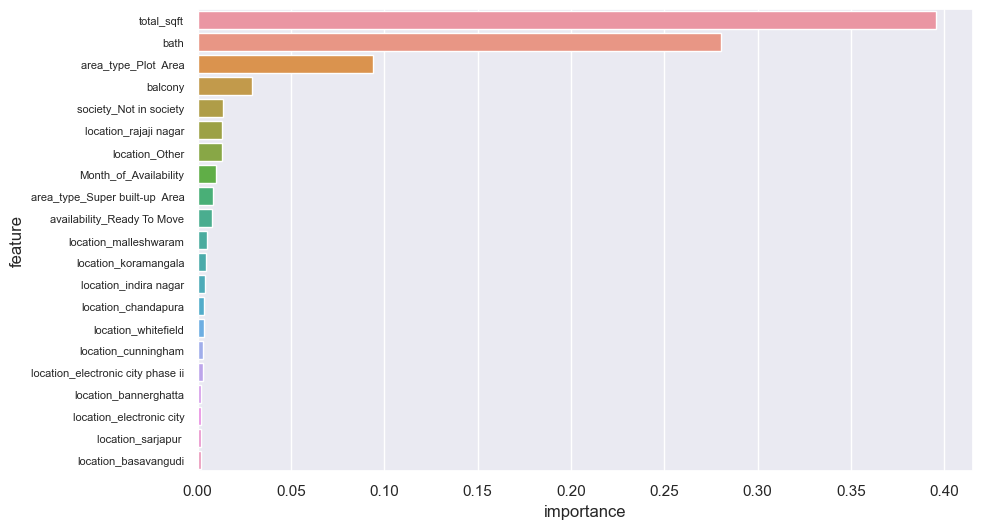

In [33]:
plt.figure(figsize=(10, 6))
labels = feature_rank[feature_rank['cumsum'] < 90]['feature']
ax = sns.barplot(feature_rank['importance'], feature_rank['feature'], order = labels)
ax.tick_params(axis = 'y',labelsize = 8)

###### We can see that almost 95% of the information is gained from top 67 columns and 5% from bottom 170 columns. These can be dropped in later trials.

In [34]:
columns_to_be_dropped = list(feature_rank[feature_rank['cumsum'] > 95]['feature'])

In [35]:
len(columns_to_be_dropped)

170

In [36]:
X_train.drop(columns_to_be_dropped, axis = 1, inplace = True)

In [37]:
X_test.drop(columns_to_be_dropped, axis = 1, inplace = True)

In [38]:
X_train.shape

(9901, 67)

## Model Building

In [39]:
# Creating instances of regression models
linreg = LinearRegression()
knn = KNeighborsRegressor()
dtree = DecisionTreeRegressor()
randomforest = RandomForestRegressor()
xgboost = XGBRegressor()

In [40]:
# Creating a function to predict target for testing set and to evaluate models
def predict_evaluate(ml_model):
    print('Model is:', ml_model)
    
    model = ml_model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print('Training score:', train_score, end = '\n\n')
    
    y_pred = model.predict(X_test)
    r2score = r2_score(y_test, y_pred)
    print('R2 score:', r2score)
          
    adj_r2score = 1 - (1 - r2score) * ((len(X_test) - 1) / (len(X_test) - X_test.shape[1] - 1))      
    print('Adjusted R2 score:', adj_r2score, end = '\n\n')
    
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

In [41]:
predict_evaluate(linreg)

Model is: LinearRegression()
Training score: 0.7021486956253193

R2 score: 0.7238093684285061
Adjusted R2 score: 0.7161246623175053

Mean Absolute Error: 0.05179673422887357
Mean Squared Error: 0.005066492469312854
Root Mean Squared Error: 0.07117929803891616


In [42]:
predict_evaluate(knn)

Model is: KNeighborsRegressor()
Training score: 0.8133995581493394

R2 score: 0.7079476900655002
Adjusted R2 score: 0.6998216498804456

Mean Absolute Error: 0.050622617405023336
Mean Squared Error: 0.005357462056223078
Root Mean Squared Error: 0.07319468598349936


In [43]:
predict_evaluate(dtree)

Model is: DecisionTreeRegressor()
Training score: 0.9787790416408673

R2 score: 0.6146560179705388
Adjusted R2 score: 0.6039342377396527

Mean Absolute Error: 0.05672294198180832
Mean Squared Error: 0.0070688218928306205
Root Mean Squared Error: 0.08407628615032077


In [44]:
predict_evaluate(randomforest)

Model is: RandomForestRegressor()
Training score: 0.9498248055430133

R2 score: 0.7482175074424908
Adjusted R2 score: 0.7412119314452512

Mean Absolute Error: 0.046637437442623525
Mean Squared Error: 0.004618745013866363
Root Mean Squared Error: 0.06796134941175289


In [45]:
predict_evaluate(xgboost)

Model is: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
Training score: 0.8596835298906007

R2 score: 0.7817719606861449
Adjusted R2 score: 0.7757000011205185

Mean Absolute Error: 0.044563255469134075
Mean Squared Error: 0.004003215863932554
Root Mean Squared Error: 0.06327097173216605


###### XGBoost is the best model we can see right now but Decision Tree and Random Forest are overfitting a lot. Let's try to manually tune the hyperparameters.

### Hyperparameter Tuning

In [46]:
params = {'n_neighbors': [4, 6, 8]}
rcv = RandomizedSearchCV(knn, params, random_state = 42)
rcv.fit(X_train, y_train)
rcv.best_params_

{'n_neighbors': 6}

In [47]:
knn_tuned = KNeighborsRegressor(n_neighbors = 6)
predict_evaluate(knn_tuned)

Model is: KNeighborsRegressor(n_neighbors=6)
Training score: 0.7988105445117095

R2 score: 0.7081895562880836
Adjusted R2 score: 0.7000702457695211

Mean Absolute Error: 0.05082982392250127
Mean Squared Error: 0.005353025217115511
Root Mean Squared Error: 0.07316437122750055


###### We were able to increase the R2 score and also reduce overfitting by decreasing the training score.

In [48]:
params = {'max_depth': [11, 12, 13],
          'max_leaf_nodes': [50, 60, 70]}
rcv = RandomizedSearchCV(dtree, params, random_state = 42)
rcv.fit(X_train, y_train)
rcv.best_params_

{'max_leaf_nodes': 60, 'max_depth': 13}

In [54]:
dtree_tuned = DecisionTreeRegressor(max_leaf_nodes = 60, max_depth = 13, random_state = 42)
predict_evaluate(dtree_tuned)

Model is: DecisionTreeRegressor(max_depth=13, max_leaf_nodes=60, random_state=42)
Training score: 0.7532312827318971

R2 score: 0.7267008161822928
Adjusted R2 score: 0.719096561483046

Mean Absolute Error: 0.05131193928351251
Mean Squared Error: 0.0050134512123135916
Root Mean Squared Error: 0.07080572866875667


###### We can see that Decision Tree model which was hugely overfitting previously with around 97.8% training score and only 61% R2 score has become a better fit model with 75% training score and 72.6% R2 score, after hyperparameter tuning.

In [50]:
params = {'max_depth': [10, 12, 14],
          'max_leaf_nodes': [225, 250, 200],
          'n_estimators': [100, 125, 75]}
rcv = RandomizedSearchCV(randomforest, params, random_state = 42)
rcv.fit(X_train, y_train)
rcv.best_params_

{'n_estimators': 100, 'max_leaf_nodes': 250, 'max_depth': 14}

In [55]:
randomforest_tuned = RandomForestRegressor(n_estimators = 100, max_leaf_nodes = 250, max_depth = 14, random_state = 42)
predict_evaluate(randomforest_tuned)

Model is: RandomForestRegressor(max_depth=14, max_leaf_nodes=250, random_state=42)
Training score: 0.8390554923239936

R2 score: 0.7593303540792335
Adjusted R2 score: 0.7526339810407405

Mean Absolute Error: 0.04772200685726969
Mean Squared Error: 0.004414888882044198
Root Mean Squared Error: 0.06644463019721156


###### We can see that Random Forest model which was hugely overfitting previously with almost 95% training score and only 74% R2 score has become a better fit model with almost 84% training score and 76% R2 score, after hyperparameter tuning.

In [52]:
params = {'max_depth': [6, 7, 8],
          'max_leaves': [20, 30, 40],
          'n_estimators': [70, 80, 90]}
rcv = RandomizedSearchCV(xgboost, params, random_state = 42)
rcv.fit(X_train, y_train)
rcv.best_params_

{'n_estimators': 80, 'max_leaves': 30, 'max_depth': 7}

In [53]:
xgboost_tuned = XGBRegressor(n_estimators = 80, max_leaves = 30, max_depth = 7, random_state = 42)
predict_evaluate(xgboost_tuned)

Model is: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=30,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=80, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)
Training score: 0.8634222421716089

R2 score: 0.7804942414748793
Adjusted R2 score: 0.7743867307517966

Mean Absolute Error: 0.04441885107554504
Mean Squared Error: 0.004026654583504393
Root Mean Squared Error: 0.06345592630719682


###### Modelling is complete and XGBoost gives us the best scores. Hence, XGBoost is chosen as the final model.